In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
from intervaltree import IntervalTree
from problem_instance import get_intervals_large, Priority
from anytree import Node as VisualNode, RenderTree
from intervaltree.node import Node
from intervaltree.interval import Interval
from anytree.exporter import DotExporter
from pprint import pprint
from itree_render import render_tree
from genetic_scheduler import genetic_algorithm

In [2]:
intervals = get_intervals_large()
df = pd.DataFrame(
    {
        'name': [interval.data.name for interval in intervals],
        'priority': [interval.data.priority for interval in intervals],
        'start': [pd.to_datetime(interval.begin) for interval in intervals],
        'end': [pd.to_datetime(interval.end) for interval in intervals]
    }
)
df['minutes_to_start'] = (df['start'] - df['start'].min()).dt.total_seconds() / 60
df['minutes_to_end'] = (df['end'] - df['start'].min()).dt.total_seconds() / 60
df['duration'] = df['minutes_to_end'] - df['minutes_to_start']
df.head()

,name,priority,start,end,minutes_to_start,minutes_to_end,duration
0,Job 0 P1,Priority.LOW,2024-11-10 22:47:00,2024-11-10 23:47:00,0.0,60.0,60.0
1,Job 1 P2,Priority.MEDIUM,2024-11-10 23:04:00,2024-11-11 00:04:00,17.0,77.0,60.0
2,Job 2 P3,Priority.HIGH,2024-11-10 23:11:00,2024-11-10 23:41:00,24.0,54.0,30.0
3,Job 3 P3,Priority.HIGH,2024-11-10 23:19:00,2024-11-11 00:19:00,32.0,92.0,60.0
4,Job 4 P2,Priority.MEDIUM,2024-11-10 23:48:00,2024-11-11 00:18:00,61.0,91.0,30.0


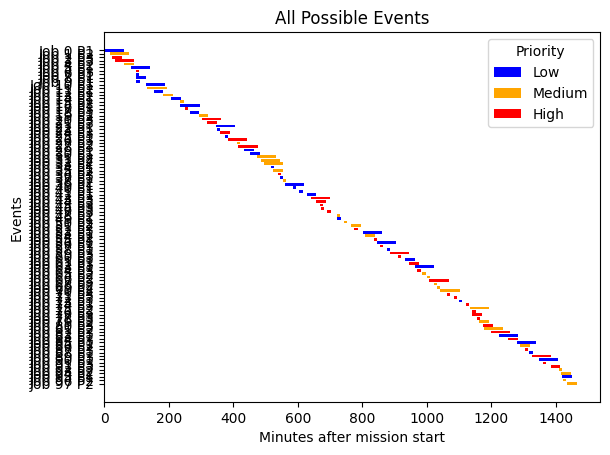

In [3]:
priority_color_mapping = { Priority.LOW: 'blue', Priority.MEDIUM: 'orange', Priority.HIGH: 'red' }
priority_str_mapping = { Priority.LOW: 'Low', Priority.MEDIUM: 'Medium', Priority.HIGH: 'High' }
plt.barh(
    y=df['name'],
    width=df['duration'],
    left=df['minutes_to_start'],
    color=df['priority'].map(priority_color_mapping),
    label=df['priority'].map(priority_str_mapping)
)

plt.gca().invert_yaxis()
plt.title('All Possible Events')
plt.xlabel('Minutes after mission start')
plt.ylabel('Events')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Priority')
plt.show()

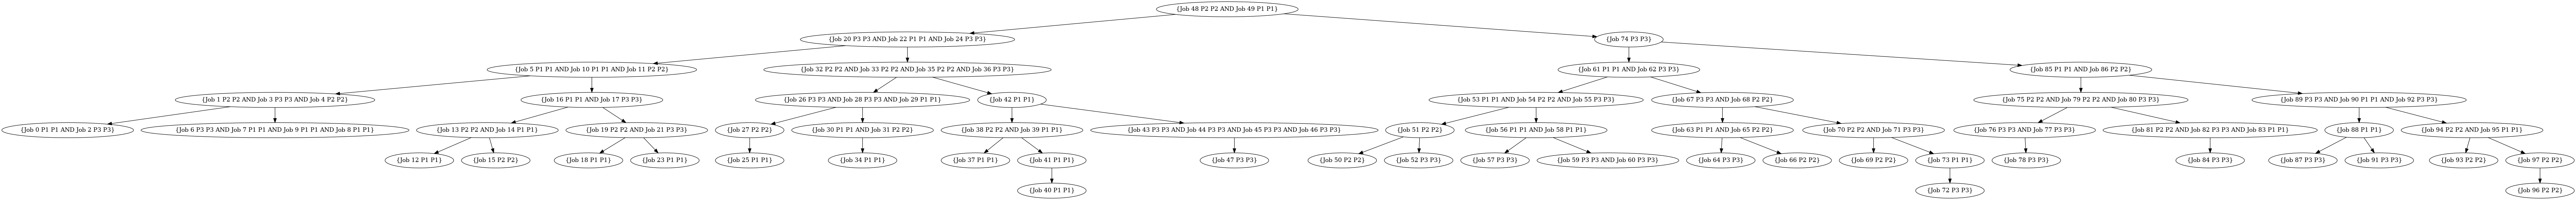

In [4]:
itree = IntervalTree(intervals)
image_filename = render_tree(itree)
from IPython.display import Image
Image(filename=image_filename)

In [5]:
conflicts = {}
for interval in intervals:
    conflicts[interval] = itree[interval.begin:interval.end]
print('===== CONFLICTS =====')
for interval, conflicted_intervals in conflicts.items():
    print(f'{interval.data} conflicts with {sorted([str(conflicted_interval.data) for conflicted_interval in conflicted_intervals])}')

===== CONFLICTS =====
Job 0 P1 P1 conflicts with ['Job 0 P1 P1', 'Job 1 P2 P2', 'Job 2 P3 P3', 'Job 3 P3 P3']
Job 1 P2 P2 conflicts with ['Job 0 P1 P1', 'Job 1 P2 P2', 'Job 2 P3 P3', 'Job 3 P3 P3', 'Job 4 P2 P2']
Job 2 P3 P3 conflicts with ['Job 0 P1 P1', 'Job 1 P2 P2', 'Job 2 P3 P3', 'Job 3 P3 P3']
Job 3 P3 P3 conflicts with ['Job 0 P1 P1', 'Job 1 P2 P2', 'Job 2 P3 P3', 'Job 3 P3 P3', 'Job 4 P2 P2', 'Job 5 P1 P1']
Job 4 P2 P2 conflicts with ['Job 1 P2 P2', 'Job 3 P3 P3', 'Job 4 P2 P2', 'Job 5 P1 P1']
Job 5 P1 P1 conflicts with ['Job 10 P1 P1', 'Job 11 P2 P2', 'Job 3 P3 P3', 'Job 4 P2 P2', 'Job 5 P1 P1', 'Job 6 P3 P3', 'Job 7 P1 P1', 'Job 8 P1 P1', 'Job 9 P1 P1']
Job 6 P3 P3 conflicts with ['Job 5 P1 P1', 'Job 6 P3 P3', 'Job 7 P1 P1', 'Job 8 P1 P1', 'Job 9 P1 P1']
Job 7 P1 P1 conflicts with ['Job 5 P1 P1', 'Job 6 P3 P3', 'Job 7 P1 P1', 'Job 8 P1 P1', 'Job 9 P1 P1']
Job 8 P1 P1 conflicts with ['Job 10 P1 P1', 'Job 5 P1 P1', 'Job 6 P3 P3', 'Job 7 P1 P1', 'Job 8 P1 P1', 'Job 9 P1 P1']
Job

In [6]:
job_conflicts_named = [sorted(value) for value in conflicts.values()]
print([[job.data for job in jobs] for jobs in job_conflicts_named])

[[<problem_instance.Job object at 0x7221fcbc3690>, <problem_instance.Job object at 0x7221fc712450>, <problem_instance.Job object at 0x7221fc712f90>, <problem_instance.Job object at 0x7221fc30d350>], [<problem_instance.Job object at 0x7221fcbc3690>, <problem_instance.Job object at 0x7221fc712450>, <problem_instance.Job object at 0x7221fc712f90>, <problem_instance.Job object at 0x7221fc30d350>, <problem_instance.Job object at 0x7221fc30d450>], [<problem_instance.Job object at 0x7221fcbc3690>, <problem_instance.Job object at 0x7221fc712450>, <problem_instance.Job object at 0x7221fc712f90>, <problem_instance.Job object at 0x7221fc30d350>], [<problem_instance.Job object at 0x7221fcbc3690>, <problem_instance.Job object at 0x7221fc712450>, <problem_instance.Job object at 0x7221fc712f90>, <problem_instance.Job object at 0x7221fc30d350>, <problem_instance.Job object at 0x7221fc30d450>, <problem_instance.Job object at 0x7221fc30d550>], [<problem_instance.Job object at 0x7221fc712450>, <problem_i

In [7]:
job_to_index = {}
for i, job in enumerate(conflicts.keys()):
    job_to_index[job] = i

job_keys = list(job_to_index.keys())
job_conflicts = [set() for _ in job_to_index]
for i, jobs in enumerate(job_conflicts_named):
    for job in jobs:
        if job_keys[i] != job:
            job_conflicts[i].add(job_to_index[job])

print(job_conflicts)

[{1, 2, 3}, {0, 2, 3, 4}, {0, 1, 3}, {0, 1, 2, 4, 5}, {1, 3, 5}, {3, 4, 6, 7, 8, 9, 10, 11}, {8, 9, 5, 7}, {8, 9, 5, 6}, {5, 6, 7, 9, 10}, {8, 5, 6, 7}, {5, 8, 11, 12, 13}, {10, 13, 12, 5}, {10, 11}, {10, 11, 14}, {16, 13, 15}, {16, 14}, {14, 15, 17, 18, 19}, {16}, {16, 19}, {16, 18, 20, 21}, {19, 21, 22, 23, 24}, {19, 20, 22}, {20, 21, 23, 24, 25, 26}, {20, 22}, {25, 26, 20, 22}, {24, 22}, {22, 24, 27, 28, 29}, {26, 28}, {26, 27, 29, 30, 31}, {26, 28, 30}, {28, 29, 31}, {32, 33, 34, 35, 28, 30}, {33, 34, 35, 36, 31}, {32, 34, 35, 36, 37, 31}, {32, 33, 35, 31}, {32, 33, 34, 36, 37, 31}, {32, 33, 35, 37}, {33, 35, 36}, {39}, {40, 41, 38}, {39}, {39}, {43}, {42, 44, 45, 46, 47}, {43, 45, 46}, {43, 44, 46}, {43, 44, 45}, {43}, {49}, {48}, set(), {52}, {51}, {56, 57, 54, 55}, {53, 55}, {56, 53, 54}, {53, 55, 57, 58, 59}, {56, 53}, {56, 59}, {56, 58, 60, 61}, {59}, {59, 62}, {64, 61, 63}, {64, 65, 66, 67, 62}, {62, 63}, {63}, {67, 63}, {66, 68, 69, 70, 71, 63}, {67}, {67}, {72, 73, 67, 71},

In [8]:
priorities = [df.iloc[i]['priority'].value for i in range(df.shape[0])]
print(priorities)

[1, 2, 3, 3, 2, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 3, 3, 1, 1, 3, 1, 3, 2, 3, 1, 1, 2, 2, 2, 1, 2, 3, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 1, 2, 2, 3, 1, 2, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 2, 2, 3, 2, 2, 2, 3, 3, 1, 3, 2, 3, 3, 3, 2, 3, 2, 3, 1, 3, 1, 2, 3, 1, 3, 1, 3, 3, 2, 2, 1, 2, 2]


In [9]:
solution, value = genetic_algorithm(job_conflicts, priorities)
print(solution)

Generation 0: Best Fitness = 10
Generation 1: Best Fitness = 11
Generation 2: Best Fitness = 11
Generation 3: Best Fitness = 15
Generation 4: Best Fitness = 17
Generation 5: Best Fitness = 17
Generation 6: Best Fitness = 17
Generation 7: Best Fitness = 17
Generation 8: Best Fitness = 22
Generation 9: Best Fitness = 22
Generation 10: Best Fitness = 24
Generation 11: Best Fitness = 24
Generation 12: Best Fitness = 24
Generation 13: Best Fitness = 26
Generation 14: Best Fitness = 26
Generation 15: Best Fitness = 26
Generation 16: Best Fitness = 28
Generation 17: Best Fitness = 28
Generation 18: Best Fitness = 30
Generation 19: Best Fitness = 30
Generation 20: Best Fitness = 30
Generation 21: Best Fitness = 30
Generation 22: Best Fitness = 33
Generation 23: Best Fitness = 35
Generation 24: Best Fitness = 35
Generation 25: Best Fitness = 35
Generation 26: Best Fitness = 35
Generation 27: Best Fitness = 35
Generation 28: Best Fitness = 35
Generation 29: Best Fitness = 35
Generation 30: Best 

In [10]:
indexes = []
for i in range(len(solution)):
    if solution[i] == 1:
        indexes.append(i)
df_sol = df.iloc[indexes]
df_sol.head()

,name,priority,start,end,minutes_to_start,minutes_to_end,duration
2,Job 2 P3,Priority.HIGH,2024-11-10 23:11:00,2024-11-10 23:41:00,24.0,54.0,30.0
7,Job 7 P1,Priority.LOW,2024-11-11 00:25:00,2024-11-11 00:35:00,98.0,108.0,10.0
11,Job 11 P2,Priority.MEDIUM,2024-11-11 01:00:00,2024-11-11 02:00:00,133.0,193.0,60.0
17,Job 17 P3,Priority.HIGH,2024-11-11 02:57:00,2024-11-11 03:07:00,250.0,260.0,10.0
21,Job 21 P3,Priority.HIGH,2024-11-11 04:06:00,2024-11-11 04:36:00,319.0,349.0,30.0


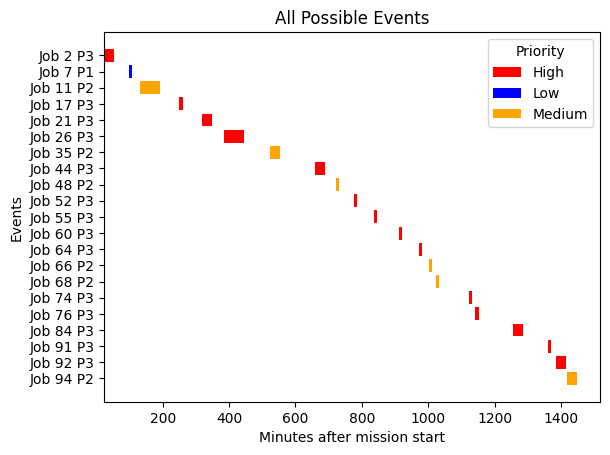

In [11]:
priority_color_mapping = { Priority.LOW: 'blue', Priority.MEDIUM: 'orange', Priority.HIGH: 'red' }
priority_str_mapping = { Priority.LOW: 'Low', Priority.MEDIUM: 'Medium', Priority.HIGH: 'High' }
plt.barh(
    y=df_sol['name'],
    width=df_sol['duration'],
    left=df_sol['minutes_to_start'],
    color=df_sol['priority'].map(priority_color_mapping),
    label=df_sol['priority'].map(priority_str_mapping)
)

plt.gca().invert_yaxis()
plt.title('All Possible Events')
plt.xlabel('Minutes after mission start')
plt.ylabel('Events')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Priority')
plt.show()